In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 14b
## Working with PyTorch
- multi-class output
- Ionosphere
- Regularization
- Dropout

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os
#import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

2024-07-20 09:12:03.616225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 09:12:03.628476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 09:12:03.632089: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 09:12:03.642011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 09:12:04.467395: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters
inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'ionosphere'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 500 # number of epochs

ALPHA = 0.001 # learning rate
WEIGHT_DECAY = 0.001 # Weight decay

BATCH_SIZE = 16

TRAIN_SIZE = int(BATCH_SIZE *18)
PATIENCE = 25
LR_FACTOR=0.1
LR_PATIENCE=10
 
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }


CMAP = plt.cm.brg

plt.rcParams.update(params)

## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [5]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [6]:
#  Split the data in training and test sets to measure performance of the model.
train_df, test_df = train_test_split(data_df,
                                     train_size=TRAIN_SIZE,
                                     stratify=data_df[data_df.columns[-1]],
                                     random_state=RANDOM_STATE )

train_df.shape, test_df.shape

((288, 35), (63, 35))

## All about CUDA

In [7]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [8]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [9]:
'''Using Singleton design pattern'''

class Transformers:
    _instance = None
    
    def __init__ (self):
        if Transformers._instance is not None:
            raise Exception ("GlobalScaler class is a singleton.")

        self.scaler = StandardScaler()
        self.encoder = LabelEncoder()
        
    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = Transformers()
        return cls._instance

In [10]:
'''
In this code, we define a custom dataset called FifaDS that takes a DataFrame as input. 

'''

class IonoDS(Dataset):
    transformers = Transformers.get_instance() # private instance variable
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device, 
                 is_train = True,
                 label_col = None
                ):
        super(IonoDS, self).__init__()

        self.df = dataframe
        self.device = device
        self.is_train = is_train
        self.scaler = self.transformers.scaler
        self.encoder = self.transformers.encoder
        self.label_col = label_col
        
        y = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)

        if self.is_train:
            self.labels = self.encoder.fit_transform(y)
            self.features = self.scaler.fit_transform(X) # fit transform train set 
        else:
            self.labels = self.encoder.transform(y)
            self.features = self.scaler.transform(X)  # transform only test set 
        
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, dtype=torch.float32, device=self.device)
        label = torch.tensor(label, dtype=torch.int64, device=self.device)
        
        return features, label

In [11]:
class Model(nn.Module):
    
    def __init__(self, input_dim):
        
        super(Model, self).__init__()

        dor1 = 0.05
        dor2 = 0.15
        dor3 = 0.25
        
        self.layer1 = nn.Linear(input_dim,26)
        self.bn1 = nn.BatchNorm1d(26)  # implementing Batch Normalization
        self.do1 = nn.Dropout(dor1)  # implementing Drop out
        self.act1 = nn.ReLU()

        self.layer2 = nn.Linear(26, 18)
        self.bn2 = nn.BatchNorm1d(18)  # implementing Batch Normalization
        self.do2 = nn.Dropout(dor2)  # implementing Drop out
        self.act2 = nn.ReLU()
 
        self.layer3 = nn.Linear(18, 10)
        self.bn3 = nn.BatchNorm1d(10)  # implementing Batch Normalization
        self.do3 = nn.Dropout(dor3)  # implementing Drop out
        self.act3 = nn.ReLU()

        self.layer4 = nn.Linear(10, 2)
        self.softmax = nn.LogSoftmax(dim= 1)
        
         
    def forward(self, x):

        # Activation Functions by layer
        
        x = self.do1(self.act1 ( self.bn1 ( self.layer1 ( x ) ) )) 
        x = self.do2(self.act2 ( self.bn2 ( self.layer2 ( x ) ) )) 
        x = self.do3(self.act3 ( self.bn3 ( self.layer3 ( x ) ) )) 
        
        output = self.softmax(self.layer4(x))
        
        return output

input_dim = 34
model = Model(input_dim).to(device) # Create model on GPU

print (model)

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.05, inplace=False)
  (act1): ReLU()
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.15, inplace=False)
  (act2): ReLU()
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do3): Dropout(p=0.25, inplace=False)
  (act3): ReLU()
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [12]:
label_col = 34
train_ds = IonoDS(train_df, is_train = True, label_col = label_col)
test_ds = IonoDS(test_df, is_train = False, label_col = label_col)

In [13]:
# Define data loaders for the training and testing datasets
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(model.parameters(),
                             lr=ALPHA, 
                             weight_decay=0.1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=LR_FACTOR, 
                                                     patience=LR_PATIENCE,
                                                     min_lr=1e-5)
# Min Loss
minLoss = float('inf')

# Path to save the model
savePath = os.path.join(modelDir, subDir, 'iono.pth')

# Train the model for multiple epochs
for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
        
    n_epoch.append(epoch)

    # Step the scheduler
    scheduler.step(test_loss)

    ##### Add Early stopping/ Saving Model #####
    if test_loss < minLoss:
        minLoss = test_loss
        counter = 0
        # Saving Model
        torch.save({ 'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss_fn,}, savePath )

    else:
        counter +=1
    if counter > PATIENCE:
        break
    #-----------------------------
    if epoch%10 == 0:
        print(f'At epoch {epoch:3d} | Loss: {train_loss:.4f} / {test_loss:.4f} | Acc:{train_acc:.4f} / {test_acc:.4f}| LR: {scheduler.get_last_lr()[0]:.5f} |Counter: {counter}')

At epoch   0 | Loss: 0.6785 / 0.6000 | Acc:0.6215 / 0.7619| LR: 0.00100 |Counter: 0
At epoch  10 | Loss: 0.2967 / 0.3363 | Acc:0.8924 / 0.8730| LR: 0.00100 |Counter: 1
At epoch  20 | Loss: 0.1868 / 0.2775 | Acc:0.9306 / 0.9048| LR: 0.00100 |Counter: 2
At epoch  30 | Loss: 0.2255 / 0.1464 | Acc:0.9306 / 0.9683| LR: 0.00100 |Counter: 0
At epoch  40 | Loss: 0.1287 / 0.2569 | Acc:0.9722 / 0.9048| LR: 0.00100 |Counter: 1
At epoch  50 | Loss: 0.1493 / 0.2319 | Acc:0.9549 / 0.9048| LR: 0.00010 |Counter: 11
At epoch  60 | Loss: 0.1684 / 0.1649 | Acc:0.9444 / 0.9048| LR: 0.00010 |Counter: 21


In [15]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc': tacc})

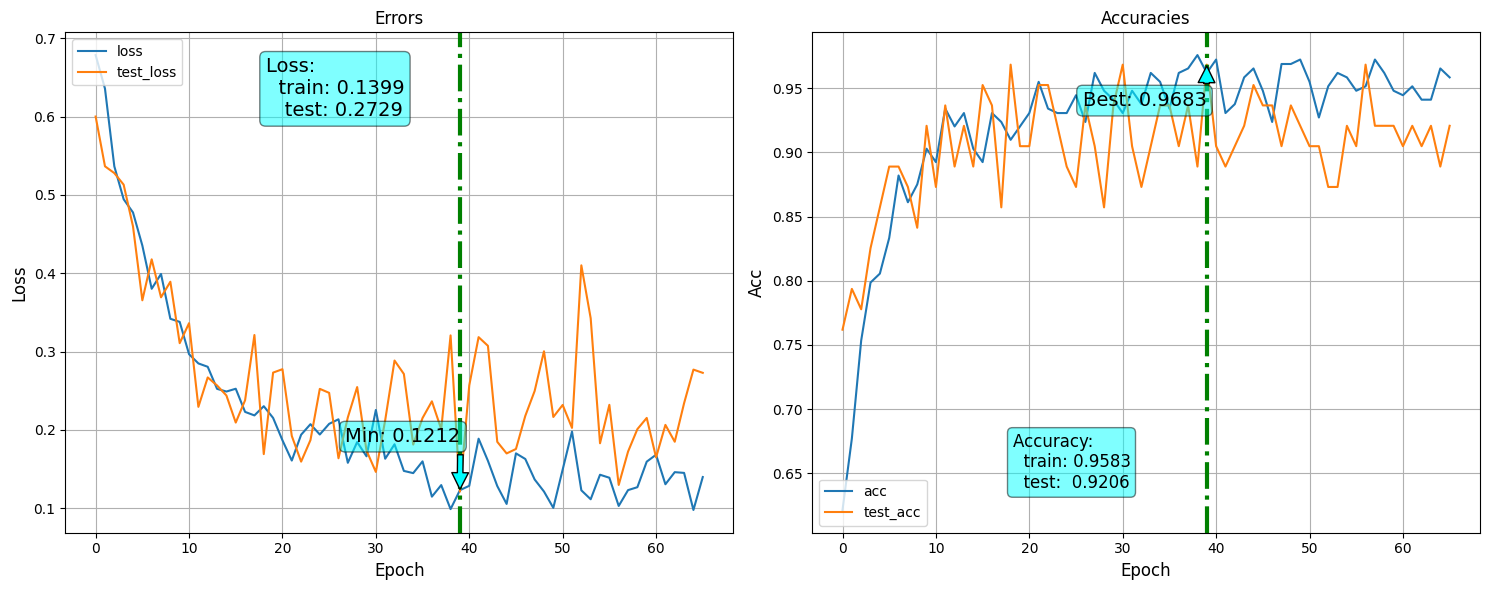

In [16]:
fn_plot_torch_hist(loss_df)

## Training Accuracy

In [35]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print (f'Train Accuracy:{accuracy_score(y_train, y_pred ):.5f}\n')

print(classification_report(y_train,y_pred))

Train Accuracy:0.95833

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       103
           1       0.96      0.98      0.97       185

    accuracy                           0.96       288
   macro avg       0.96      0.95      0.95       288
weighted avg       0.96      0.96      0.96       288



In [18]:
train_ds.transformers.encoder.classes_

array(['b', 'g'], dtype=object)

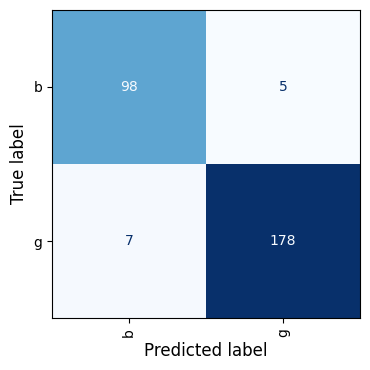

In [19]:
class_names = {k : v for k, v in enumerate(train_ds.transformers.encoder.classes_)}
fn_plot_confusion_matrix(y_train,y_pred, class_names)

## Testing Accuracy

In [34]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = model(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print (f'Test Accuracy:{accuracy_score(y_test, y_pred ):.5f}\n')

print(classification_report(y_test, y_pred ))

Test Accuracy:0.90476

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.93      0.93      0.93        40

    accuracy                           0.90        63
   macro avg       0.90      0.90      0.90        63
weighted avg       0.90      0.90      0.90        63



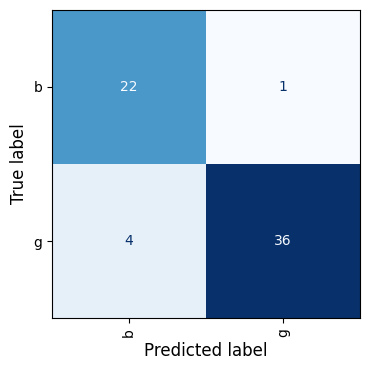

In [21]:
fn_plot_confusion_matrix(y_test, y_pred, class_names)

In [22]:
model1 = Model(input_dim).to(device)

In [26]:
model_dict = torch.load(savePath)
model_dict.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])

In [28]:
model_dict['model_state_dict'].keys()

odict_keys(['layer1.weight', 'layer1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer2.weight', 'layer2.bias', 'bn2.weight', 'bn2.bias', 'bn2.running_mean', 'bn2.running_var', 'bn2.num_batches_tracked', 'layer3.weight', 'layer3.bias', 'bn3.weight', 'bn3.bias', 'bn3.running_mean', 'bn3.running_var', 'bn3.num_batches_tracked', 'layer4.weight', 'layer4.bias'])

In [29]:

model1.load_state_dict(model_dict['model_state_dict'])
model1.eval()

Model(
  (layer1): Linear(in_features=34, out_features=26, bias=True)
  (bn1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.05, inplace=False)
  (act1): ReLU()
  (layer2): Linear(in_features=26, out_features=18, bias=True)
  (bn2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.15, inplace=False)
  (act2): ReLU()
  (layer3): Linear(in_features=18, out_features=10, bias=True)
  (bn3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do3): Dropout(p=0.25, inplace=False)
  (act3): ReLU()
  (layer4): Linear(in_features=10, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [32]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = model1(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print (f'Test Accuracy:{accuracy_score(y_test, y_pred ):.5f}\n')

print(classification_report(y_test, y_pred ))

Test Accuracy:0.96825

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.97      0.97      0.97        40

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63

